# Final Project - Advanced Analysis in Python

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, KFold,LeaveOneOut, LeavePOut, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# !pip install movecolumn
import movecolumn as mc

## EDA step - Understanding the data
Before we'll start the exercise and answer the questions, let's first understand what we're facing with - our data.

In [2]:
# Read the file
file_name = '/data/notebook_files/output_all_students_Train_v10.csv'  # note: you can right-click on your file and copy-paste the path here
dataset = pd.read_csv(file_name)
dataset.drop(columns= 'Unnamed: 23', inplace = True)
dataset.rename(columns={'hasElevator ':'hasElevator', 'hasParking ':'hasParking', 'hasBars ':'hasBars',
                        'hasStorage ':'hasStorage', 'condition ':'condition', 'hasAirCondition ':'hasAirCondition',
                        'hasBalcony ':'hasBalcony', 'hasMamad ':'hasMamad', 'handicapFriendly ':'handicapFriendly',
                        'entranceDate ':'entranceDate','furniture ':'furniture', 'publishedDays ':'publishedDays',
                        'description ':'description'}, inplace = True)
dataset.sample(3)

,City,type,room_number,Area,Street,number_in_street,city_area,price,num_of_images,floor_out_of,...,hasStorage,condition,hasAirCondition,hasBalcony,hasMamad,handicapFriendly,entranceDate,furniture,publishedDays,description
455,באר שבע,דירה,5,148,עוזי נרקיס,8,רמות ב,1890000,4.0,קומה 3 מתוך 5,...,FALSE,משופץ,TRUE,TRUE,TRUE,TRUE,גמיש,אין,3,מה זמן אתם כבר מחפשים דירת 5 חדרים למכירה ברמו...
281,זכרון יעקב,דירה,4 חד׳,"96 מ""ר",פרנק אנה,2,רמת צבי,2220000,6.0,קומה 1 מתוך 5,...,TRUE,חדש,TRUE,TRUE,TRUE,TRUE,גמיש,מלא,NaN,"דירת 4 חדרים 96 מ""ר משופצת כמו חדשה + מרפסת ש..."
112,רחובות,דירה,4 חד׳,"110 מ""ר",אחד העם,1,מרכז העיר,2300000,0.0,קומה 1 מתוך 8,...,FALSE,שמור,TRUE,FALSE,TRUE,FALSE,לא צויין,לא צויין,0,"מיקום סופר מרכזי , בניין נעים ונקי שכנים נחמדי..."


In [3]:
print (f'The length of the dataset is {len(dataset)} entries')

The length of the dataset is 699 entries


### Missing Values:

Let's check the missing values:

In [4]:
dataset.isna().sum().sort_values(ascending = False)

publishedDays 394
number_in_street 190
city_area 41
description 26
Street 23
room_number 14
floor_out_of 14
Area 13
num_of_images 9
price 5
hasBars 3
hasAirCondition 2
handicapFriendly 2
hasMamad 2
hasBalcony 2
hasParking 2
hasStorage 2
hasElevator 2
condition 1
type 0
entranceDate 0
furniture 0
City 0
dtype: int64

In [5]:
print("The rows that don't have 'Price' values are {:.4f}% of the dataset".format((dataset.price.isna().sum()/len(dataset))*100))

The rows that don't have 'Price' values are 0.7153% of the dataset


**Since we can't fill price, and it's part of the dataset, we'll drop those rows.**

In [6]:
dataset.dropna(subset=['price'], inplace = True)

### Data Types
Let's check the data types:

In [7]:
dataset.dtypes

City object
type object
room_number object
Area object
Street object
number_in_street object
city_area object
price object
num_of_images float64
floor_out_of object
hasElevator object
hasParking object
hasBars object
hasStorage object
condition object
hasAirCondition object
hasBalcony object
hasMamad object
handicapFriendly object
entranceDate object
furniture object
publishedDays object
description object
dtype: object

### Price column

In [8]:
dataset.price.head()

0 3600000
1 2550000
2 2650000
3 2450000
4 2720000
Name: price, dtype: object

**We need to convert it to float type for better analysis later on this project.**  
To do so, we using `Regular Expressions` to retrieve the numbers from the strings, and convert them to float type.

In [9]:
def clean_price(price):
    if re.findall(r'(?:₪)?([\d,]+)', price) and isinstance(price, str):
        return float(re.findall(r'(?:₪)?([\d,]+)', price)[0].replace(',', ''))
    return None

In [10]:
dataset['price'] = dataset['price'].apply(clean_price)

**Again, we'll drop rows with no price.**

In [11]:
dataset.dropna(subset=['price'], inplace = True)

### Area column
We'll work as we worked on the price column, with other 're' pattern which will fit the current column.

In [12]:
dataset.Area.head()

0 137
1 84
2 120
3 110
4 120
Name: Area, dtype: object

In [13]:
# There's entities which includes the string 'עסקאות באיזור', we'll ignore them since they not includes actual area size.
def clean_area(area):
    if isinstance(area, str) and re.findall(r'[\d,]+', area) and 'עסקאות באיזור' not in area:
        return int(re.findall(r'[\d,]+', area)[0])
    return None

In [14]:
dataset['Area'] = dataset['Area'].apply(clean_area)

### Room Number column

In [15]:
dataset.room_number.sample(5)

560 5 חד׳
14 4
148 6 חד׳
332 5
418 3.5
Name: room_number, dtype: object

We can see that there's few options for room number to appear, so we'll define function to handle this column.

In [16]:
def extract_room(room):
    try:
        room_num = re.findall(r'\d\.*\d*',room)
        if len(room_num) == 1: # in case of only one digit (e.g. 6.5 rooms).
            return float(room_num[0])
        elif len(room_num) > 1: # in case of range of digits (e.g. 3-5 rooms).
                numbers = [int(x) for x in room_num]
                mean_room = np.mean(numbers)
                return mean_room
    except:
        return None

In [17]:
dataset.room_number = dataset.room_number.apply(extract_room)

In [18]:
print("The rows that don't have 'room_number' values are {:.4f}% of the dataset".format((dataset.room_number.isna().sum()/len(dataset))*100))

The rows that don't have 'room_number' values are 1.5873% of the dataset


### City column
There's cities that appears few times in different ways, e.g. Nahariya. **Let's fix that.**

In [19]:
# Change the city names that appear more than once.

def clean_city(city):
    return city.strip().replace('נהרייה', 'נהריה')

In [20]:
dataset.City = dataset.City.apply(clean_city)

### Floors column
We want to break this column into two columns: the property's floor ('floor') and the entiere building floor ('total_floors').

In [21]:
dataset.floor_out_of.head()

0 קומה 11 מתוך 19
1 קומה 6 מתוך 9
2 קומה 2 מתוך 7
3 קומה 2 מתוך 6
4 קומה 3 מתוך 6
Name: floor_out_of, dtype: object

In [22]:
def extract_floors(floors):
    floors = str(floors)
    if not floors or floors in ['None', 'nan']: # handle Null values
        return None,None
    floor_numbers = re.findall(r'\d\.*\d*',floors)
    try: # if the floors appear in the appropriate way (floor X out of Y floors)
        floor = int(floor_numbers[0])
        out_of_floors = int(floor_numbers[1])
        if floor <= out_of_floors:
            return floor, out_of_floors
        else: # if the floors wrote in the opposite way
            return out_of_floors, floor
    except: # in case that there is only one floor
        if floors == 'קומת קרקע':
            return 0, None
        elif floors == 'קומת מרתף':
            return -1, None
        elif floors and isinstance(floor_numbers[0], str):
            return int(floor_numbers[0]), None

In [23]:
dataset[['floor','total_floors']] = dataset.floor_out_of.apply(lambda row: pd.Series(extract_floors(row)))
dataset.drop(columns='floor_out_of', inplace = True)

### Handle the Boolean Columns
Since there are different values for 'True' of 'False' in each of the boolean column, we need to normalize them.

In [24]:
bool_cols = ['hasElevator', 'hasParking','hasBars', 'hasStorage', 'hasAirCondition', 'hasBalcony', 'hasMamad', 'handicapFriendly']

In [25]:
def boolean_encoding(row):
    truth_vals = ['True', 'TRUE', '1', 'כן', 'יש', 'yes']
    return 1 if str(row) in truth_vals or 'יש' in str(row) else 0

In [26]:
dataset[bool_cols] = dataset[bool_cols].applymap(boolean_encoding)

### entranceDate Column
We'll convert this column into categorial one.

In [27]:
def extract_flexibility(ent_date):
    if not ent_date or ent_date == 'לא צויין':
        return 'not_defined'
    if 'גמיש' in ent_date:
        return 'flexible'
    elif ent_date == 'מיידי':
        return 'less_than_6_months'
    else:
        ent_date = datetime.strptime(ent_date, '%d/%m/%Y')
        today = datetime.today().date() # Today's date
        delta = (ent_date.date()-today).days # Delta in days
        delta= delta/30.44 # Delta in months
        if delta < 6:
            return 'less_than_6_months'
        elif delta < 12:
            return '6-12_months'
        return 'above_year'

In [28]:
dataset.entranceDate = dataset.entranceDate.apply(extract_flexibility)

### Fixing Address Column

In [29]:
def fix_address(address):
    street = str(address[0])
    number = str(address[1])
    area = str(address[2])
    if 'בשכונת ' in street:
        area = re.sub(r'[^א-ת\s]|בשכונת', '', street).strip() # Replace the special characters with ''
        try:
            number = re.search(r'\d+', number).group() # Find the first sequence of digits
        except:
            number=None
        street=None
    else:
        street = re.sub(r'[^א-ת\s]|בשכונת', '', street).strip() # Replace the special characters with ''
        try:
            number = re.search(r'\d+', number).group() # Find the first sequence of digits
        except:
            try:
                number = re.search(r'\d+', address[0]).group()
            except:
                number=None
        area= re.sub(r'[^א-ת\s]|בשכונת', '', area).strip() # Replace the special characters with ''
    if street == '':
        street= None
    if number == '':
        number= None    
    if area == '':
        area= None
    return street, number, area

In [30]:
address_cols = ['Street','number_in_street','city_area']
dataset[address_cols] = dataset[address_cols].apply(lambda x: pd.Series(fix_address(x)), axis = 1)

### Fix Categories and Fill missing values

In [31]:
dataset.condition.fillna('לא צויין', inplace = True)
dataset.condition = dataset.condition.replace({'None':'לא צויין','FALSE':'לא צויין'})

dataset.num_of_images.fillna(0, inplace = True)

dataset.description.fillna('אין', inplace = True)
dataset.description = dataset.description.replace({'None':'אין', 'None ':'אין'})

dataset.publishedDays = dataset.publishedDays.replace({'Nan':'None', '-':'None', 'None ':'None', 'חדש': 0, 'חדש!': 0})

dataset.total_floors.fillna(dataset.floor, inplace=True)

In [32]:
conditions = (dataset['floor'].isna()) & (dataset['type'].isin(["קוטג'", 'דו משפחתי']))
dataset.loc[conditions, 'floor'] = 0
dataset.loc[conditions, 'total_floors'] = 0

mean_floor = round(dataset.floor.mean())
dataset.floor.fillna(mean_floor, inplace = True)

mean_tot_floor = round(dataset.total_floors.mean())
dataset.total_floors.fillna(mean_tot_floor, inplace = True)

In [33]:
dataset.isna().sum().sort_values(ascending = False)

publishedDays 390
number_in_street 218
city_area 46
Street 42
Area 19
room_number 11
City 0
hasBalcony 0
floor 0
description 0
furniture 0
entranceDate 0
handicapFriendly 0
hasMamad 0
hasStorage 0
hasAirCondition 0
condition 0
type 0
hasBars 0
hasParking 0
hasElevator 0
num_of_images 0
price 0
total_floors 0
dtype: int64

In [34]:
print("The rows that don't have 'Area' values are {:.4f}% of the dataset".format((dataset.Area.isna().sum()/len(dataset))*100))

The rows that don't have 'Area' values are 2.7417% of the dataset


In [35]:
mean_room_size = (dataset.Area/dataset.room_number).mean()
mean_room_size

27.62019713657603

Fill missing values in 'Area' using the `mean_room_size`:

In [36]:
conditions = dataset['Area'].isna()
dataset[conditions][['Area','room_number']]

,Area,room_number
33,NaN,6.0
97,NaN,3.0
161,NaN,3.0
185,NaN,4.0
204,NaN,3.5
205,NaN,5.5
208,NaN,3.0
239,NaN,3.5
261,NaN,4.0
317,NaN,4.0


In [37]:
# Now we can fill the Area for the entires who missing it.
dataset.loc[dataset.Area.isna(), 'Area'] = mean_room_size * dataset.loc[dataset.Area.isna(), 'room_number']

In [38]:
# Now we can fill the room number for the entires who missing it.
dataset.loc[dataset.room_number.isna(), 'room_number'] = dataset.loc[dataset.room_number.isna(), 'Area'] / mean_room_size  

### Feature Engineering

In [39]:
dataset['Shopping_Center'] = dataset.description.apply(lambda x: int(any(map(lambda value: value in x, ['מסחרי','בילוי']))))

edu_list = ['חינוך','בית ספר','בתי ספר',' גנים','מוסד','אוניברסיט']
dataset['Education'] = dataset.description.apply(lambda x: int(any(map(lambda value: value in x, edu_list))))

### Handle Outliers

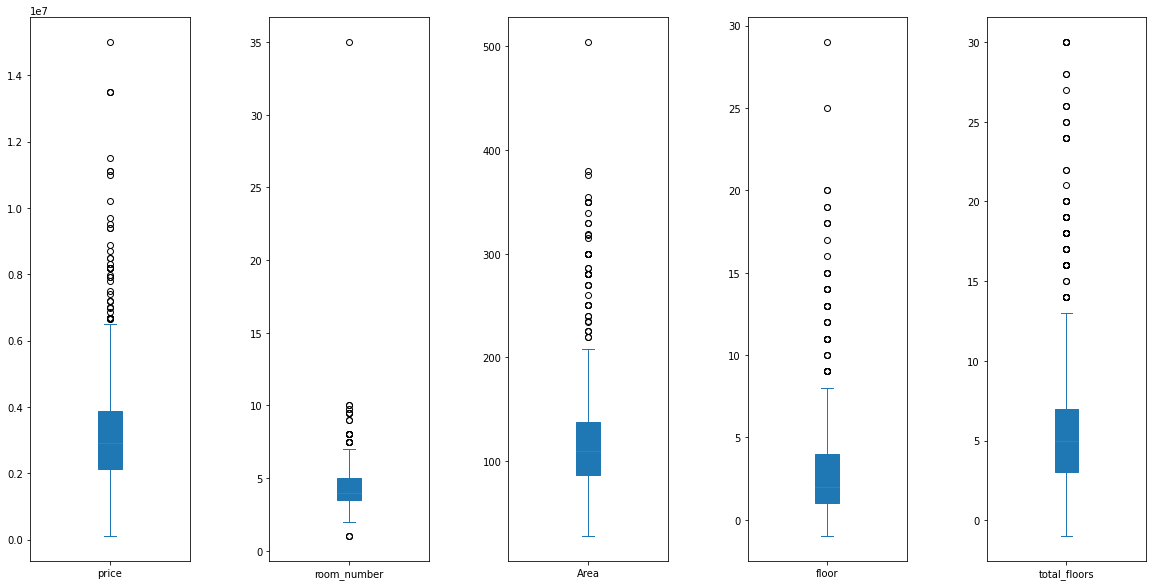

In [40]:
df_to_plot =  dataset[['price', 'room_number', 'Area','floor','total_floors']]
df_to_plot.plot(subplots=True, layout=(1,5), kind='box', figsize=(20,10), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

We can see that there's a lot of outliers, which can harm the prediction. Let's drop them.

In [41]:
print("The number of properties which thier price is less than 100,000  and higher than 6,500,000 are: {:,.0f}"\
    .format(len(dataset[(dataset.price <= 100000)]) + len(dataset[dataset.price >= 8000000])))
dataset = dataset[(dataset.price > 100000) & (dataset.price < 8000000)].reset_index(drop=True)

The number of properties which thier price is less than 100,000  and higher than 6,500,000 are: 25


In [42]:
dataset[dataset.room_number < 2 ]

,City,type,room_number,Area,Street,number_in_street,city_area,price,num_of_images,hasElevator,...,hasMamad,handicapFriendly,entranceDate,furniture,publishedDays,description,floor,total_floors,Shopping_Center,Education
286,קרית ביאליק,אחר,1.0,50.000000,קרן היסוד,None,מרכז העיר,1250000.0,0.0,0,...,0,1,not_defined,אין,NaN,חנות חד מפלסית חזיתית ברחוב מרכזי,1.0,1.0,0,0
402,תל אביב,דירה,1.0,30.000000,דיזנגוף,342,הצפון הישן החלק הצפוני,2290000.0,0.0,0,...,0,0,not_defined,מלא,NaN,"נוף מהמם לים!! בנין שמור וצבוע, אינטרקום וקוד ...",0.0,0.0,0,0
658,רעננה,נחלה,1.0,27.620197,רעננה צפון,None,רעננה צפון,1500000.0,0.0,0,...,0,1,not_defined,לא צויין,NaN,"באיזור הכי חם ברעננה, בקרבת HP, SAP ועוד\nקרקע...",0.0,0.0,0,0


In [43]:
print("The number of properties with 10 or more rooms are: {:,.0f}"\
    .format(len(dataset[dataset.room_number >= 10 ]) + len(dataset[dataset.room_number < 2 ])))
dataset = dataset[(dataset.room_number < 10 ) & (dataset.room_number >= 2 )].reset_index(drop=True)

The number of properties with 10 or more rooms are: 5


In [44]:
elev_idx = dataset[(dataset.total_floors >= 6) & (dataset.hasElevator == 0)].index

dataset.loc[elev_idx, 'hasElevator'] = 1

In [45]:
print("The number of properties with 10 or more rooms are: {:,.0f}".format(len(dataset[dataset.Area >= 300 ])))
dataset = dataset[dataset.Area < 300].reset_index(drop=True)

The number of properties with 10 or more rooms are: 7


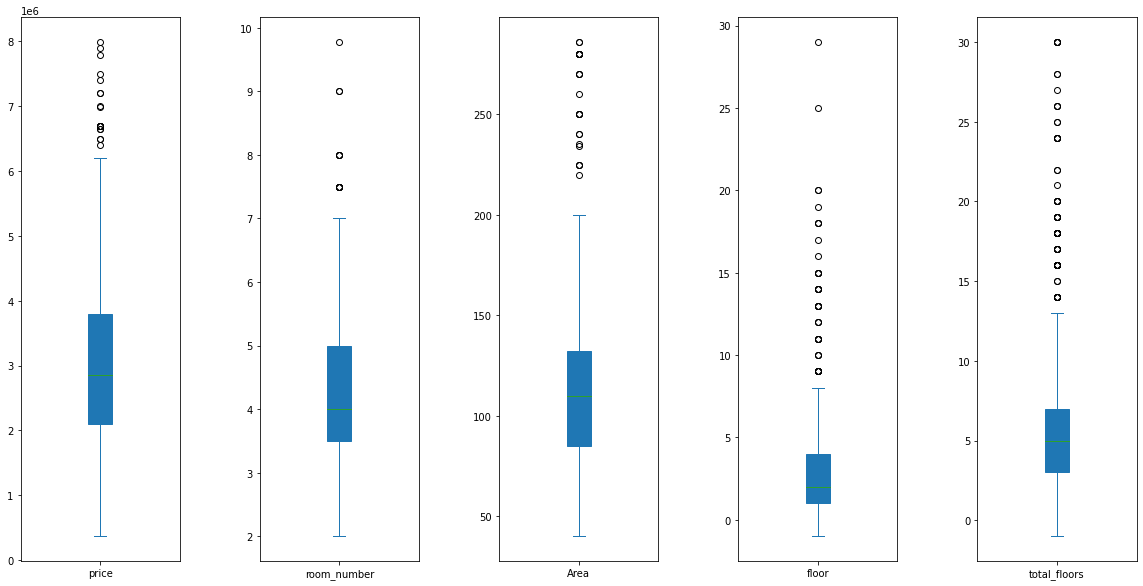

In [46]:
df_to_plot =  dataset[['price', 'room_number', 'Area','floor','total_floors']]
df_to_plot.plot(subplots=True, layout=(1,5), kind='box', figsize=(20,10), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

**In addition**, an attempt was made to use **Google's API** in order to get the <u>coordinates of the cities</u> and use them as an additional feature.  
Since these features did not contribute to the accuracy of the model, the code appears as a comment and is not used further.

In [127]:
# import requests
# def get_lat_lng(address_string,api_key):
#     url="https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s" % (address_string,api_key)
#     response = requests.get(url).json()
#     longitude = response['results'][0]['geometry']['location']['lng']
#     latitude = response['results'][0]['geometry']['location']['lat']
#     return longitude, latitude

# api_key = 'YOUR_API_KEY'

# cities = pd.DataFrame([i for i in dataset.City.unique()],columns=['City'])
# cities[['longitude', 'latitude']] = cities.City.apply(lambda x: pd.Series(get_lat_lng(x,api_key)))

# cities = pd.read_csv('/data/notebook_files/cities_cordinates.csv')
# # cities.drop(columns='Unnamed: 0', inplace = True)

# dataset = dataset.merge(cities, on="City", how="left")
# # dataset.drop(columns= 'City', inplace = True)
# dataset

### We need to make the same cleaning and feature engineering to the test set.
To do so, we'll write a function that use all of the function we already wrote.

In [47]:
def clean_data(dataset):
    # Rename columns
    dataset.rename(columns={'hasElevator ':'hasElevator', 'hasParking ':'hasParking', 'hasBars ':'hasBars',
                        'hasStorage ':'hasStorage', 'condition ':'condition', 'hasAirCondition ':'hasAirCondition',
                        'hasBalcony ':'hasBalcony', 'hasMamad ':'hasMamad', 'handicapFriendly ':'handicapFriendly',
                        'entranceDate ':'entranceDate','furniture ':'furniture', 'publishedDays ':'publishedDays',
                        'description ':'description'}, inplace = True)
    
    # Fix and Clean Values

    dataset['price'] = dataset['price'].apply(clean_price)
    dataset['Area'] = dataset['Area'].apply(clean_area)
    dataset.room_number = dataset.room_number.apply(extract_room)
    dataset.City = dataset.City.apply(clean_city)
    dataset[['floor','total_floors']] = dataset.floor_out_of.apply(lambda row: pd.Series(extract_floors(row)))
    dataset.drop(columns='floor_out_of', inplace = True)

    bool_cols = ['hasElevator', 'hasParking','hasBars', 'hasStorage',
                 'hasAirCondition', 'hasBalcony', 'hasMamad', 'handicapFriendly']
    dataset[bool_cols] = dataset[bool_cols].applymap(boolean_encoding)
    
    dataset.entranceDate = dataset.entranceDate.apply(extract_flexibility)
    
    address_cols = ['Street','number_in_street','city_area']
    dataset[address_cols] = dataset[address_cols].apply(lambda x: pd.Series(fix_address(x)), axis = 1)

    # Fill Missing Values

    dataset.condition.fillna('לא צויין', inplace = True)
    dataset.condition = dataset.condition.replace({'None':'לא צויין','FALSE':'לא צויין'})

    dataset.num_of_images.fillna(0, inplace = True)

    dataset.description = dataset.description.replace({'None':'אין', 'None ':'אין'})
    dataset.description.fillna('אין', inplace = True)

    dataset.publishedDays = dataset.publishedDays.replace({'Nan':'None', '-':'None', 'None ':'None', 'חדש': 0, 'חדש!': 0})

    dataset.total_floors.fillna(dataset.floor, inplace=True)
    
    conditions = (dataset['floor'].isna()) & (dataset['type'].isin(["קוטג'", 'דו משפחתי']))
    dataset.loc[conditions, 'floor'] = 0
    dataset.loc[conditions, 'total_floors'] = 0

    mean_floor = round(dataset.floor.mean())
    dataset.floor.fillna(mean_floor, inplace = True)

    mean_tot_floor = round(dataset.total_floors.mean())
    dataset.total_floors.fillna(mean_tot_floor, inplace = True)

    # Feature Engineering
    mean_room_size = (dataset.Area/dataset.room_number).mean()
    # Now we can fill the Area for the entires who missing it.
    dataset.loc[dataset.Area.isna(), 'Area'] = mean_room_size * dataset.loc[dataset.Area.isna(), 'room_number']
    
    # Now we can fill the room number for the entires who missing it.
    dataset.loc[dataset.room_number.isna(), 'room_number'] = dataset.loc[dataset.room_number.isna(), 'Area'] / mean_room_size  
    
    
    dataset['Shopping_Center'] = dataset.description.apply(lambda x: int(any(map(lambda value: value in x, ['מסחרי','בילוי']))))

    edu_list = ['חינוך','בית ספר','בתי ספר',' גנים','מוסד','אוניברסיט']
    dataset['Education'] = dataset.description.apply(lambda x: int(any(map(lambda value: value in x, edu_list))))

    # Drop untanted columns
    dataset = dataset.drop(columns=['city_area','Street', 'number_in_street', 'num_of_images','publishedDays'])

    return dataset

## Pre Processing data before modeling

The first step before prediction, and after the EDA and data cleansing step, is preprocessing.  
This step includes several actions the data going through in order to get ready to the modeling step.  
The steps we chose to do are **One Hot Encoding** and **Min Max Scaler**, on the following columns:  
* **One Hot Encoding** - City, type, condition, entranceDate and furniture.
* **Min Max Scaler** - room_number, Area, floor, total_floors.

First, we'll define out pipelines in order to perform accurate preprocessing before the prediction.  
We'll have 3 pipelines:  
1. **Categorical Transformer** which perform <u>One Hot Encoding</u> on the relevant columns.
2. **Numeric Transformer** which perform <u>Min Max Scaler</u> on the relevant columns.
3. **Preprocessor Column Transformer** which <u>combines</u> the previous two into one pipeline.

In [48]:
categorical_features = ['City', 'type', 'condition', 'entranceDate', 'furniture']

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(min_frequency=5,handle_unknown = 'infrequent_if_exist',sparse_output=False,drop='first')),
    ]
)
numeric_features = ['room_number', 'Area', 'floor', 'total_floors']

numeric_transformer = Pipeline( 
    steps=[("scaler", MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

**You can see the preprocessor as flow chart here:**

In [49]:
preprocessor

ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('scaler', MinMaxScaler())]),
 ['room_number', 'Area', 'floor',
 'total_floors']),
 ('cat',
 Pipeline(steps=[('encoder',
 OneHotEncoder(drop='first',
 handle_unknown='infrequent_if_exist',
 min_frequency=5,
 sparse_output=False))]),
 ['City', 'type', 'condition', 'entranceDate',
 'furniture'])]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. ColumnTransformer ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('scaler', MinMaxScaler())]),
 ['room_number', 'Area', 'floor',
 'total_floors']),
 ('cat',
 Pipeline(steps=[('encoder',
 OneHotEncoder(drop='first',
 handle_unknown='infrequent_if_exist',
 min_frequency=5,
 sparse_output=False))]),
 ['City', 'type', 'condition', 'entranceDate',
 'furniture'])]) num ['room_number', 'Area', 'floor', 'total_floors'] MinMaxScaler MinMaxScaler() cat ['City', 'type', 'condition', 'entranceDate', 'furniture'] OneHotEncoder OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist',
 min_frequency=5, sparse_output=False)

**Now, we can move the data through the preprocesser.**  
**BUT**, before do so, we want to drop several columns we found as irrelevant (and even damage) the modeling and predicting.

In [50]:
dataset = mc.MoveToLast(dataset,'price')
X = dataset.iloc[:,:-1]
y = dataset.price
X.drop(columns=['city_area','Street', 'number_in_street', 'num_of_images','publishedDays'], inplace=True)

In [51]:
X.sample()

,City,type,room_number,Area,hasElevator,hasParking,hasBars,hasStorage,condition,hasAirCondition,hasBalcony,hasMamad,handicapFriendly,entranceDate,furniture,description,floor,total_floors,Shopping_Center,Education
650,רעננה,דירת גן,5.0,153.0,0,1,0,0,חדש,0,0,0,1,flexible,לא צויין,למכירה ברעננה דירת גן מרהיבה!במיקום מרכזי ומבו...,0.0,0.0,0,0


## Modeling, Cross validation and predicting
Now, as we have our X and y data ready and we've got the preprocessor - **We are ready to run the data through the model!**  

We'll use the ElasticNet model as our Machine Learning predicting model.

We now have to **split** out X and y into train and test split, **fit** the model on the train set and **evaluate** it using the test set.  

During the exercise we tried <u>several methods</u>, such as the traditional **train test split**, **K-Folds Cross validation** and more.  
We found that the **<u>Leave One Out Cross Validation</u>** is the **best way** to fit and evaluate our models, because this way, each iteration we have large train set, as only one sample serve us as test set.

**<u>In the following code cell we'll preform the following actions:</u>**  
1. **Split** the data into train and test sets, as in each iteration only one sample kept as test sample.
2. **Fit and transform** the <u>preprocessor</u> using X_train
3. **Transform** the fitted preprossesor on the X_test
4. **Fit** the ElasticNet model (Note that during our work we found that the **best parameters** are `alpha=0.1` and `l1_ration=0.95`).
5. **Predict** the price of the test sample
6. **Evaluate** the model performance: If the rmse is less than 350,000, keep it in `models` list.
7. **Repeat** steps 1-6 over the entire data.

In [53]:
# Create new list for model evaluating
test_mean_err =[]
models_mse =[]
models_rmse =[]
models = []
i = 0 # model indacator
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    i += 1 
    print(f'Model #{i}')
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
    # Fit and transform the preprocessor using X_train

    train_set_prepro = preprocessor.fit_transform(X_train)
    X_train = X_train.drop(columns=['description','City', 'type', 'condition', 'entranceDate', 'furniture',
                                  'room_number','Area','floor','total_floors'])
    train_set_prepro = pd.DataFrame(train_set_prepro, columns=preprocessor.get_feature_names_out())
    train_set_prepro.index = X_train.index
    X_train = pd.concat([X_train,train_set_prepro], axis=1)
    
    # Transform the fitted preprossesor on the X_test
    
    test_set_prepro = preprocessor.transform(X_test)
    X_test = X_test.drop(columns=['description','City', 'type', 'condition', 'entranceDate', 'furniture',
                                  'room_number','Area','floor','total_floors'])
    test_set_prepro = pd.DataFrame(test_set_prepro, columns=preprocessor.get_feature_names_out())
    test_set_prepro.index = X_test.index
    X_test = pd.concat([X_test,test_set_prepro], axis=1)
    
    # Fit the model
    model = ElasticNet(alpha=0.1, l1_ratio=0.95)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # We chose to take the models who had rmse lower then 350,000
    if rmse < 350000:
        models.append(model)
        models_mse.append(mse)
        models_rmse.append(rmse)

Model #1
Model #2
Model #3
Model #4
Model #5
Model #6
Model #7
Model #8
Model #9
Model #10
Model #11
Model #12
Model #13
Model #14
Model #15
Model #16
Model #17
Model #18
Model #19
Model #20
Model #21
Model #22
Model #23
Model #24
Model #25
Model #26
Model #27
Model #28
Model #29
Model #30
Model #31
Model #32
Model #33
Model #34
Model #35
Model #36
Model #37
Model #38
Model #39
Model #40
Model #41
Model #42
Model #43
Model #44
Model #45
Model #46
Model #47
Model #48
Model #49
Model #50
Model #51
Model #52
Model #53
Model #54
Model #55
Model #56
Model #57
Model #58
Model #59
Model #60
Model #61
Model #62
Model #63
Model #64
Model #65
Model #66
Model #67
Model #68
Model #69
Model #70
Model #71
Model #72
Model #73
Model #74
Model #75
Model #76
Model #77
Model #78
Model #79
Model #80
Model #81
Model #82
Model #83
Model #84
Model #85
Model #86
Model #87
Model #88
Model #89
Model #90
Model #91
Model #92
Model #93
Model #94
Model #95
Model #96
Model #97
Model #98
Model #99
Model #100
Model #1

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


You can see that among the models we kept, the **mean RMSE** is **157,592** with **Standard Deviation** of **95,383**.  
 
We find this quite accurate, especially when considering the high price of the properties and the wide various of the different data points.

In [54]:
print(f'Mean MSE {np.mean(models_mse)}, Std: {np.std(models_mse)}\nMean RMSE {np.mean(models_rmse)}, Std: {np.std(models_rmse)}')

Mean MSE 33933259553.7398, Std: 32705815786.16906
Mean RMSE 157592.18310996346, Std: 95383.24473604128


**Because it's now important what model we take next to production, we'll take randomly one of them.**

In [55]:
final_model = models[random.randint(0,len(models))]
final_model

ElasticNet(alpha=0.1, l1_ratio=0.95) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. ElasticNet ElasticNet(alpha=0.1, l1_ratio=0.95)

### About featue importance
We can learn about **how important** each data point and how much it contributed to the model. for example, you can see that the model found that the **city Tel Aviv** is the **most important feature**.  

This way we learned more about our data during the exercise, knowledge that helped us to decide what columns we should drop.

In [56]:
feature_importance = pd.DataFrame([final_model.coef_], columns = final_model.feature_names_in_).T
feature_importance[0].sort_values(ascending=False)

cat__City_תל אביב 1.905212e+06
num__Area 1.900043e+06
num__room_number 1.157041e+06
cat__City_רעננה 9.755826e+05
cat__City_רמת גן 6.937179e+05
 ... 
cat__City_צפת -7.340861e+05
cat__City_באר שבע -8.790965e+05
cat__type_דירה -9.266832e+05
cat__City_דימונה -9.976243e+05
cat__City_בית שאן -1.367616e+06
Name: 0, Length: 62, dtype: float64

## Predict price for new data
Thanks to the efficiency with which the code was written, includes the `clean_data` function and the `preprocessor` pipeline,  
We can now take any new dataset and predict its properties' prices.

In [57]:
# Read the file
file_name = '/data/notebook_files/Dataset_for_test.csv'
test_set = pd.read_csv(file_name)

We need to perform the `clean_data` function before doing any other action

In [58]:
test_set.head(3)

,City,type,room_number,Area,Street,number_in_street,city_area,price,num_of_images,floor_out_of,...,hasStorage,condition,hasAirCondition,hasBalcony,hasMamad,handicapFriendly,entranceDate,furniture,publishedDays,description
0,פתח תקווה,בית פרטי,4,600,עזרא ונחמיה,44.0,עמישב,6999999,2,קומת קרקע,...,FALSE,משופץ,TRUE,FALSE,FALSE,FALSE,לא צויין,מלא,NaN,"דירת מרווחת ומוארת במצב מצוין, 4 חדרים גדולים,..."
1,דימונה,דירה,2,45,דיין משה,117.0,נאות קטיף,520000,0,קומה 1 מתוך 4,...,0,לא צויין,1,0,0,0,לא צויין,מלא,11.0,אזור טוב ושקט בדימונה.שכנים נוחים.הדירה מושכרת...
2,ירושלים,דירה,3 חד׳,"94 מ""ר",רבדים,6.0,ארנונה (תלפיות),"₪3,450,000",11,קומה 8 מתוך 8,...,כן,משופץ,כן,כן,לא,כן,לא צויין,חלקי,NaN,"הדירה משופצת ומושקעת , נמצאת בקרבת תחבורה ציב..."


Perform the `clean_data` function on the test set

In [59]:
test_set = clean_data(test_set)

We'll hold the price under `real_price`

In [60]:
real_price = test_set.price
test_set = test_set.drop(columns='price')

Now, we'll perform the same process we've done during the model fitting, but this time on the real properties for which we ask to predict the price.

In [61]:
test_set_prepro = preprocessor.transform(test_set)
test_set = test_set.drop(columns=['description','City', 'type', 'condition', 'entranceDate', 'furniture',
                                  'room_number','Area','floor','total_floors'])
test_set_prepro = pd.DataFrame(test_set_prepro, columns=preprocessor.get_feature_names_out())
test_set_prepro.index = test_set.index
test_set = pd.concat([test_set,test_set_prepro], axis=1)

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Predict the properties' prices:**

In [62]:
y_pred = final_model.predict(test_set)

Error table:

In [63]:
values = pd.DataFrame([y_pred,real_price,np.abs(real_price-y_pred)]).T
predicted_table = values.rename(columns={0:'Predicted',1:'Real_Price', 2:'Absolute_Error'})
predicted_table

,Predicted,Real_Price,Absolute_Error
0,7.071654e+06,6999999.0,7.165516e+04
1,2.139262e+05,520000.0,3.060738e+05
2,3.056115e+06,3450000.0,3.938847e+05
3,3.350317e+06,3800000.0,4.496827e+05
4,5.128139e+06,5555555.0,4.274158e+05
5,4.198136e+06,3730000.0,4.681356e+05
6,2.380431e+06,1870000.0,5.104313e+05
7,2.826138e+06,2290000.0,5.361382e+05
8,2.843119e+06,3150000.0,3.068808e+05
9,1.697804e+06,1430000.0,2.678039e+05


In [64]:
rmse = np.sqrt((predicted_table.Absolute_Error**2).mean())
print(f'The RMSE of the model on the test set is {rmse} with STD of {np.std(predicted_table.Absolute_Error)}')

The RMSE of the model on the test set is 586022.0805094637 with STD of 343431.91855035734


## Save the relevant files in order to upload them to flask app

In [65]:
# Save the fitted model using pickle
with open('properties_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Save the fitted ColumnTransformer using pickle
with open('fitted_preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)